### Amazon Review를 이용한 추천 시스템 실습 - suprise 패키지 사용

[블로그 링크](simonezz.tistory.com/42)



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
# from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [8]:
# 데이터 불러오기
electronics_data=pd.read_csv("ratings_Electronics (1).csv", names=['userId', 'productId', 'Rating','timestamp'])

In [9]:
# 데이터 모양 확인
print(electronics_data.head())
print(electronics_data.shape)

           userId   productId  Rating   timestamp
0   AKM1MP6P0OYPR  0132793040     5.0  1365811200
1  A2CX7LUOHB2NDG  0321732944     5.0  1341100800
2  A2NWSAGRHCP8N5  0439886341     1.0  1367193600
3  A2WNBOD3WNDNKT  0439886341     3.0  1374451200
4  A1GI0U4ZRJA8WN  0439886341     1.0  1334707200
(7824482, 4)


In [10]:
# 데이터 자르기
electronics_data=electronics_data.iloc[:1048576, 0:]

In [12]:
# 데이터 타입 확인
electronics_data.dtypes

userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object

In [16]:
electronics_data.describe()['Rating']

count    1.048576e+06
mean     3.973380e+00
std      1.399329e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [19]:
# 평가 range 결정하기
print("max of rating : %d" %(electronics_data.Rating.max()))
print("min of rating : %d" %(electronics_data.Rating.min()))

max of rating : 5
min of rating : 1


### Missing values 수

In [20]:
print("Numbe of missing values across columns: \n", electronics_data.isnull().sum())

Numbe of missing values across columns: 
 userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


### Ratings

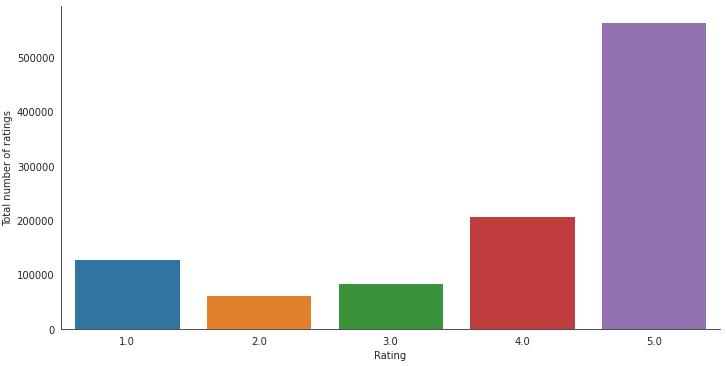

In [22]:
with sns.axes_style("white"):
    g = sns.factorplot("Rating", data=electronics_data, 
                      aspect=2.0, kind="count")
    g.set_ylabels("Total number of ratings")

In [23]:
print("Total data")
print("-"*50)
print("\nTotal num of ratings:" , electronics_data.shape[0])
print("Total num of Users: ", len(np.unique(electronics_data.userId)))
print("Total num of products: ", len(np.unique(electronics_data.productId)))

Total data
--------------------------------------------------

Total num of ratings: 1048576
Total num of Users:  786330
Total num of products:  61894


In [24]:
# 의미 없는 column 버리기
electronics_data.drop(['timestamp'], axis=1, inplace=True)

In [25]:
electronics_data.head()

,userId,productId,Rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


### Ratings 분석

In [26]:
num_of_rated_products_per_user=electronics_data.groupby(by="userId")['Rating'].count().sort_values(ascending=False)
num_of_rated_products_per_user.head() # 평가를 많이한 혹은 높은 점수를 준 사람 순서

userId
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: Rating, dtype: int64

In [27]:
num_of_rated_products_per_user.describe()
# 대부분 user 당 하나의 product에만 평가함

count    786330.000000
mean          1.333506
std           1.385612
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         412.000000
Name: Rating, dtype: float64

In [28]:
quantiles = num_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

# 각각에 해당하는 백분위수 입력하고 각 백분위 수에 맞는 quantile 반환
# interpolation: 보간 방법>> 큰거로!

In [29]:
quantiles

0.00      1
0.01      1
0.02      1
0.03      1
0.04      1
       ... 
0.96      3
0.97      4
0.98      4
0.99      6
1.00    412
Name: Rating, Length: 101, dtype: int64

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

<AxesSubplot:title={'center':'Quantiles and their Values'}>

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

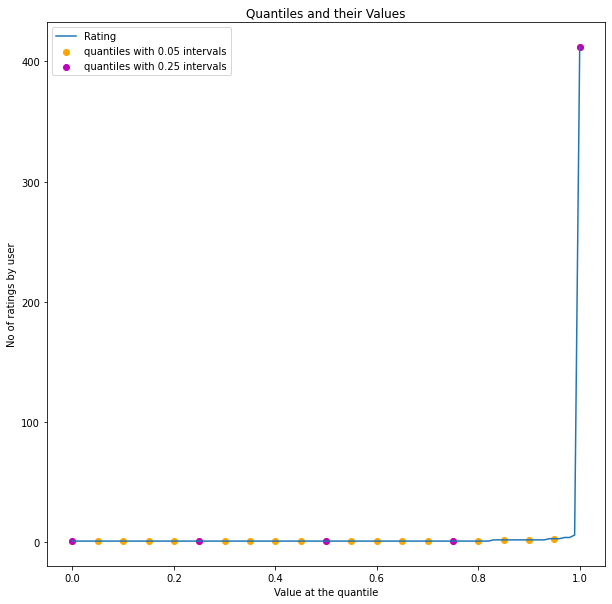

In [31]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()

#qunatiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")

# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best') # 알아서 최적의 위치를 계산하여 삽입한다
plt.show()

In [33]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(num_of_rated_products_per_user >= 50)) )


 No of rated product more than 50 per user : 38



### Popularity Based Recommendation
: 가장 많이 구입되거나 높게 평가된 아이템들을 추천함. 개인에 맞는 추천 시스템은 아님

In [38]:
# 평가가 50번 이상된 상품들을 가져옴
new_df=electronics_data.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

In [39]:
new_df.head()

,userId,productId,Rating
183,A1BKC6B7YHYTVV,0972683275,4.0
184,AWVFSIB42LHKJ,0972683275,4.0
185,A36MQBNADRH8YY,0972683275,5.0
186,A3SRXMPLAEZ6DP,0972683275,4.0
187,A20XXTXWF2TCPY,0972683275,5.0


In [40]:
new_df.shape

(677947, 3)

Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[Text(-500.0, 0, ''),
 Text(0.0, 0, ''),
 Text(500.0, 0, ''),
 Text(1000.0, 0, ''),
 Text(1500.0, 0, ''),
 Text(2000.0, 0, ''),
 Text(2500.0, 0, ''),
 Text(3000.0, 0, ''),
 Text(3500.0, 0, ''),
 Text(4000.0, 0, ''),
 Text(4500.0, 0, '')]

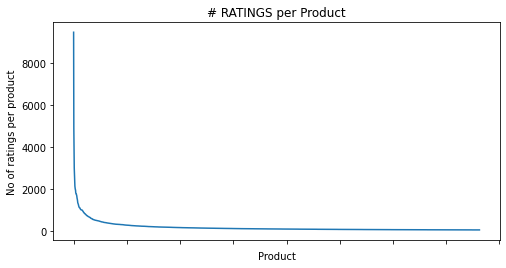

In [42]:
num_of_ratings_per_product=new_df.groupby(by="productId")['Rating'].count().sort_values(ascending=False)

fig=plt.figure(figsize=plt.figaspect(.5)) # 그래프 크기를 0.5만큼 확대(즉 축소되는것)
ax=plt.gca() # 현재의 사이즈를 반환
plt.plot(num_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [43]:
# 평가들을 상품 아이디로 묶고 각 상품의 평균 평점을 낸다
new_df.groupby('productId')['Rating'].mean().head()

productId
0972683275    4.470980
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
Name: Rating, dtype: float64

In [44]:
# 평균 높은것부터 출력
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

productId
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
B000I1X3W8    4.869565
Name: Rating, dtype: float64

In [45]:
# 평가 된 수 기준 정렬
new_df.groupby("productId")['Rating'].count().sort_values(ascending=False).head()

productId
B0002L5R78    9487
B0001FTVEK    5345
B000I68BD4    4903
B000BQ7GW8    4275
B00007E7JU    3523
Name: Rating, dtype: int64

In [46]:
# 평점 평균을 이용하여 dataFrame 만들기
ratings_mean_count=pd.DataFrame(new_df.groupby('productId')['Rating'].mean())

In [47]:
ratings_mean_count.head()

,Rating
productId,
0972683275,4.470980
1400501466,3.560000
1400501520,4.243902
1400501776,3.884892
1400532620,3.684211


In [48]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())

In [49]:
ratings_mean_count['rating_counts'].max() # rating수가 가장 많은 거

9487

<Figure size 432x432 with 0 Axes>

<AxesSubplot:>

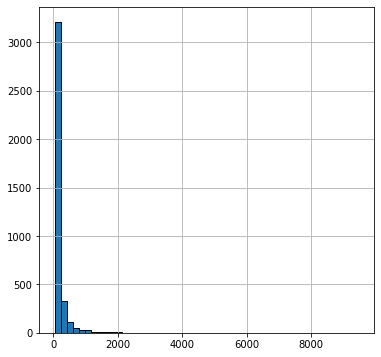

In [51]:
plt.figure(figsize=(6,6))
plt.rcParams['patch.force_edgecolor']=True # 테두리 지정: default black
ratings_mean_count['rating_counts'].hist(bins=50) # 리뷰수

<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

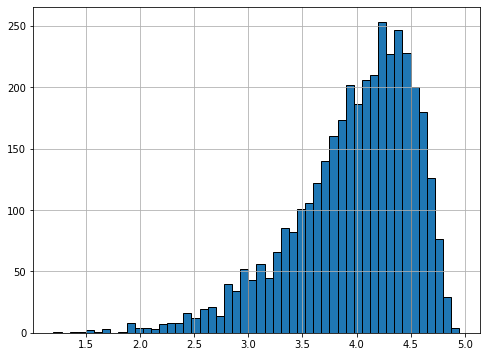

In [52]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor']=True 
ratings_mean_count['Rating'].hist(bins=50) #평점 평균

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

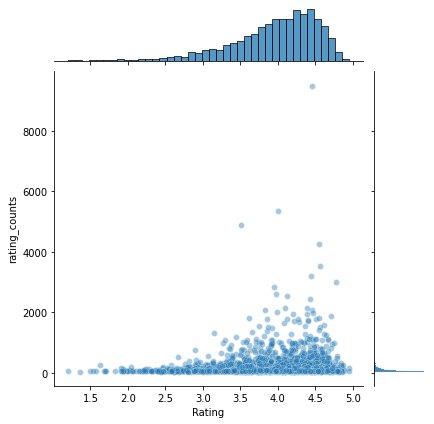

In [53]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

<AxesSubplot:xlabel='productId'>

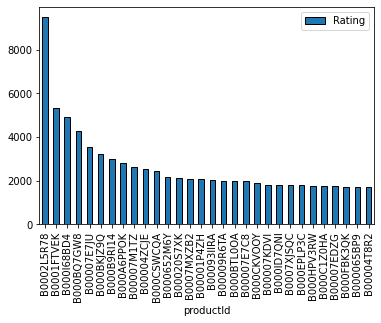

In [54]:
popular_products=pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular=popular_products.sort_values("Rating", ascending=False)
most_popular.head(30).plot(kind='bar')
# 리뷰수가 가장 많은 제품의 히스토그램